In [1]:
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ioff()
import tifffile, csv, numpy as np
from skimage.morphology import closing, opening, square, disk, ball
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu, sobel, threshold_local, threshold_niblack
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import mahotas as mh
import cv2, skimage
import os, copy


/home/user/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
directory = "/media/ula/D/ppp/fos_gfp_tmaze2/processing/"
path_comm = "m{}{}_tst_sa.tif"
out_name = "result_m{}{}.tif"
result_file = "result_label_m{}{}.csv"


field_names_coords = ['X', 'Y', 'Z']
scale_coeff = {
    'xy': 1.2, 
    'z': 2
}
radius_microns = 5
min_dist = 1.2*radius_microns


tolerance = radius_microns

In [3]:
def dist(centroid1, centroid2):
    return np.sqrt((scale_coeff['xy']*(centroid1[0]-centroid2[0]))**2
                   +(scale_coeff['xy']*(centroid1[1]-centroid2[1]))**2
                   +(scale_coeff['z']*(centroid1[2]-centroid2[2]))**2)


In [4]:
def calculate_markers(stack_slice):
    elev_map_ = np.array(sobel(stack_slice))
    
    thre_otsu = threshold_otsu(stack_slice)
    thre_val = threshold_local(stack_slice, 75, offset=-0.4*thre_otsu)
    stack_slice[stack_slice > thre_val] = 255
    stack_slice[stack_slice <= thre_val] = 0
    
    thresh = stack_slice
    kernel = disk(1)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
    sure_bg = cv2.dilate(opening,kernel,iterations=1)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers_ = cv2.connectedComponents(sure_fg)
    markers_ = markers_+1
    markers_[unknown==255] = 0
    return markers_, opening, elev_map_

In [5]:
def prepare_img_for_watershed(image_ts, out_name):
    elev_map = np.empty_like(image_ts)
    markers = np.empty_like(image_ts)

    for idx, im in enumerate(image_ts):
        markers_, opening, elev_map_ = calculate_markers(im)
        markers[idx] = markers_
        image_ts[idx] = opening
        elev_map[idx] = elev_map_

    with tifffile.TiffWriter(out_name) as tiff:   
        for im in image_ts:
            tiff.save(im)
    return elev_map, markers

In [6]:
def watershed_label_img(elev_map, markers, image_ts):
    

    labels = label(watershed(-elev_map, markers, connectivity=2))
    #labels = label(image_ts)

    return labels



In [7]:
def identify_cells(label_image):
    cells = []
    total = len(regionprops(label_image))
    with open(result_file,"w") as result:
        wtr = csv.writer( result )
        wtr.writerow( field_names_coords )
        for region in regionprops(label_image):
            if region.area > 20:
                coords = np.flip(region.centroid).astype(int)+np.array([1,1,1])
                cells.append(coords)
                wtr.writerow(coords)
                
    unique_cells = []
    print("non unique cells ", len(cells))
    for idx_t, c1 in enumerate(cells):
        if idx_t% 10000 == 0:
            print(idx_t/total*100, '%')
        idx = 0
        for c2 in unique_cells:
            if dist(c1, c2) < min_dist:
                break;
            idx += 1
        if idx == len(unique_cells):
            unique_cells.append(c1)
        else:
            unique_cells[idx] = ((c1+c2)/2).astype(int)
              
    return unique_cells

In [8]:
def save_result(result_file, cells, header=None):
    with open(result_file,"w") as result:
        wtr = csv.writer( result )
        if header != None:
            wtr.writerow( header )
        for cell in cells:
            wtr.writerow(cell)

In [9]:
def find_cells(mouse, scan_code):
    source_path = directory + path_comm.format(mouse, scan_code)
    result_img_path = directory + out_name.format(mouse, scan_code)
    result_csv_path = directory + result_file.format(mouse, scan_code)
    
    image_ts = io.imread(source_path)
    
    elev_map, markers = prepare_img_for_watershed(image_ts, result_img_path)
    label_image = watershed_label_img(elev_map, markers, image_ts)
    cells = identify_cells(label_image)
    print(mouse, scan_code, len(cells))
    save_result(result_csv_path, cells, field_names_coords)
    
    

In [10]:
mouse = '8'
reg_code = '_r1'

starting_sess = 1
for i in range(1):
    find_cells(mouse, 's' + str(starting_sess + i) + reg_code)

non unique cells  3504
0.0 %
8 s1_r1 1188
non unique cells  4349
0.0 %
8 s2_r1 1489
non unique cells  4557
0.0 %
8 s3_r1 1637


In [11]:
def read_coords(filename):
    ret = []
    with open(filename,"r") as source:
        rdr = csv.reader(source)
        next(rdr)
        for row in rdr:
            ret.append(row)
    return np.array(ret).astype(int)


In [12]:
source_path = directory + path_comm.format(mouse, 's1' + reg_code)
image_ts = io.imread(source_path)


<IPython.core.display.Javascript object>


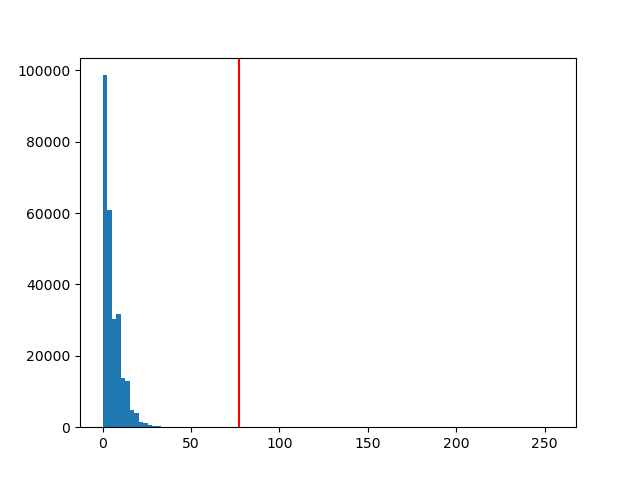

In [13]:
stack_slice = image_ts[70]
plt.hist(stack_slice.flatten(), 100)
plt.axvline(threshold_otsu(stack_slice), color = "red")
plt.show()